In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr

from geonss.sp3 import interpolate_orbit_positions, correct_positions_with_antex
from geonss.rinexmanager.util import load_cached_rinex
from geonss.rinexmanager.antex import load_cached_antex
from geonss.navigation import calculate_satellite_positions
from geonss.constellation import select_constellations
from geonss.plotting import plot_distance

In [2]:
test_data_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "tests/data/"))
navigation = load_cached_rinex(os.path.join(test_data_dir, "BRDC00IGS_R_20250980000_01D_MN.rnx"))
sp3 = load_cached_rinex(os.path.join(test_data_dir, "COD0OPSRAP_20250980000_01D_05M_ORB.SP3"))
antex = load_cached_antex(os.path.join(test_data_dir, "igs20.atx"))

In [3]:
navigation = select_constellations(navigation, gps=True, galileo=True)
sp3 = select_constellations(sp3, gps=True, galileo=True)

# choose a random subset of 3 satellites of each constellation for testing
satellites = np.concatenate([
    np.random.choice(navigation.sv.values[navigation.sv.str.startswith("G")], 3, replace=False),
    np.random.choice(navigation.sv.values[navigation.sv.str.startswith("E")], 3, replace=False)
])

In [4]:
times = pd.date_range(
    start='2025-04-08 00:30:00',
    end='2025-04-08 23:30:00',
    freq='30s'
)

# Create a minimal dataset with just sv coordinate and time coordinate
ds = xr.Dataset(
    coords={
        'sv': satellites,
        'time': times
    },
)

In [5]:
def distance(da1: xr.DataArray, da2: xr.DataArray):
    """
    Calculate the Euclidean distance between satellite positions in two datasets.

    Args:
        da1 (xr.DataArray): First dataset with 'ECEF' coordinate
        da2 (xr.DataArray) Second dataset with 'ECEF' coordinate

    Returns:
        xr.DataArray: Euclidean distance between positions with dimensions (time, sv)
    """
    # Calculate the position differences along ECEF dimension
    position_diff = da1 - da2

    # Use np.linalg.norm to calculate the Euclidean distance along the ECEF dimension
    return xr.apply_ufunc(
        lambda x: np.linalg.norm(x, axis=-1),
        position_diff,
        input_core_dims=[['ECEF']],
        vectorize=True
    )

In [6]:
positions_sp3 = interpolate_orbit_positions(sp3, ds)

In [7]:
positions_ephemeris = calculate_satellite_positions(navigation, ds)

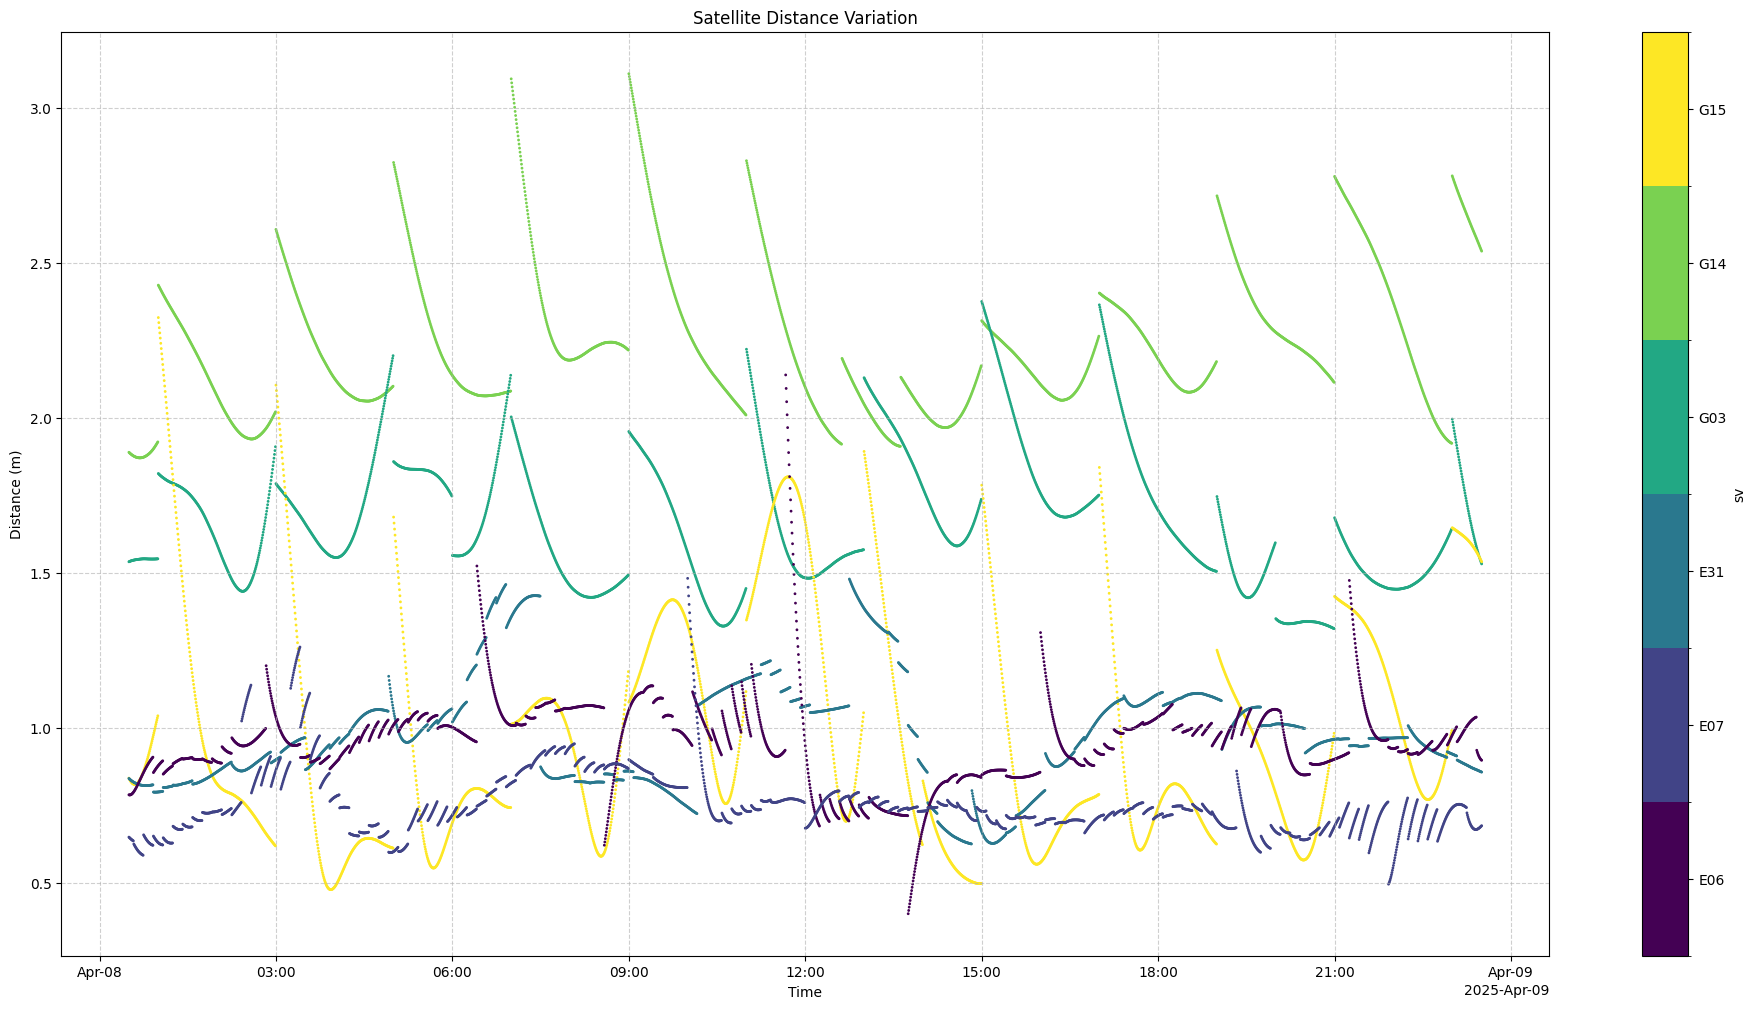

In [8]:
distance_no_correction = distance(positions_sp3.position, positions_ephemeris.position)
plot_distance(distance_no_correction)

In [13]:
corrected_positions = correct_positions_with_antex(positions_sp3, antex)

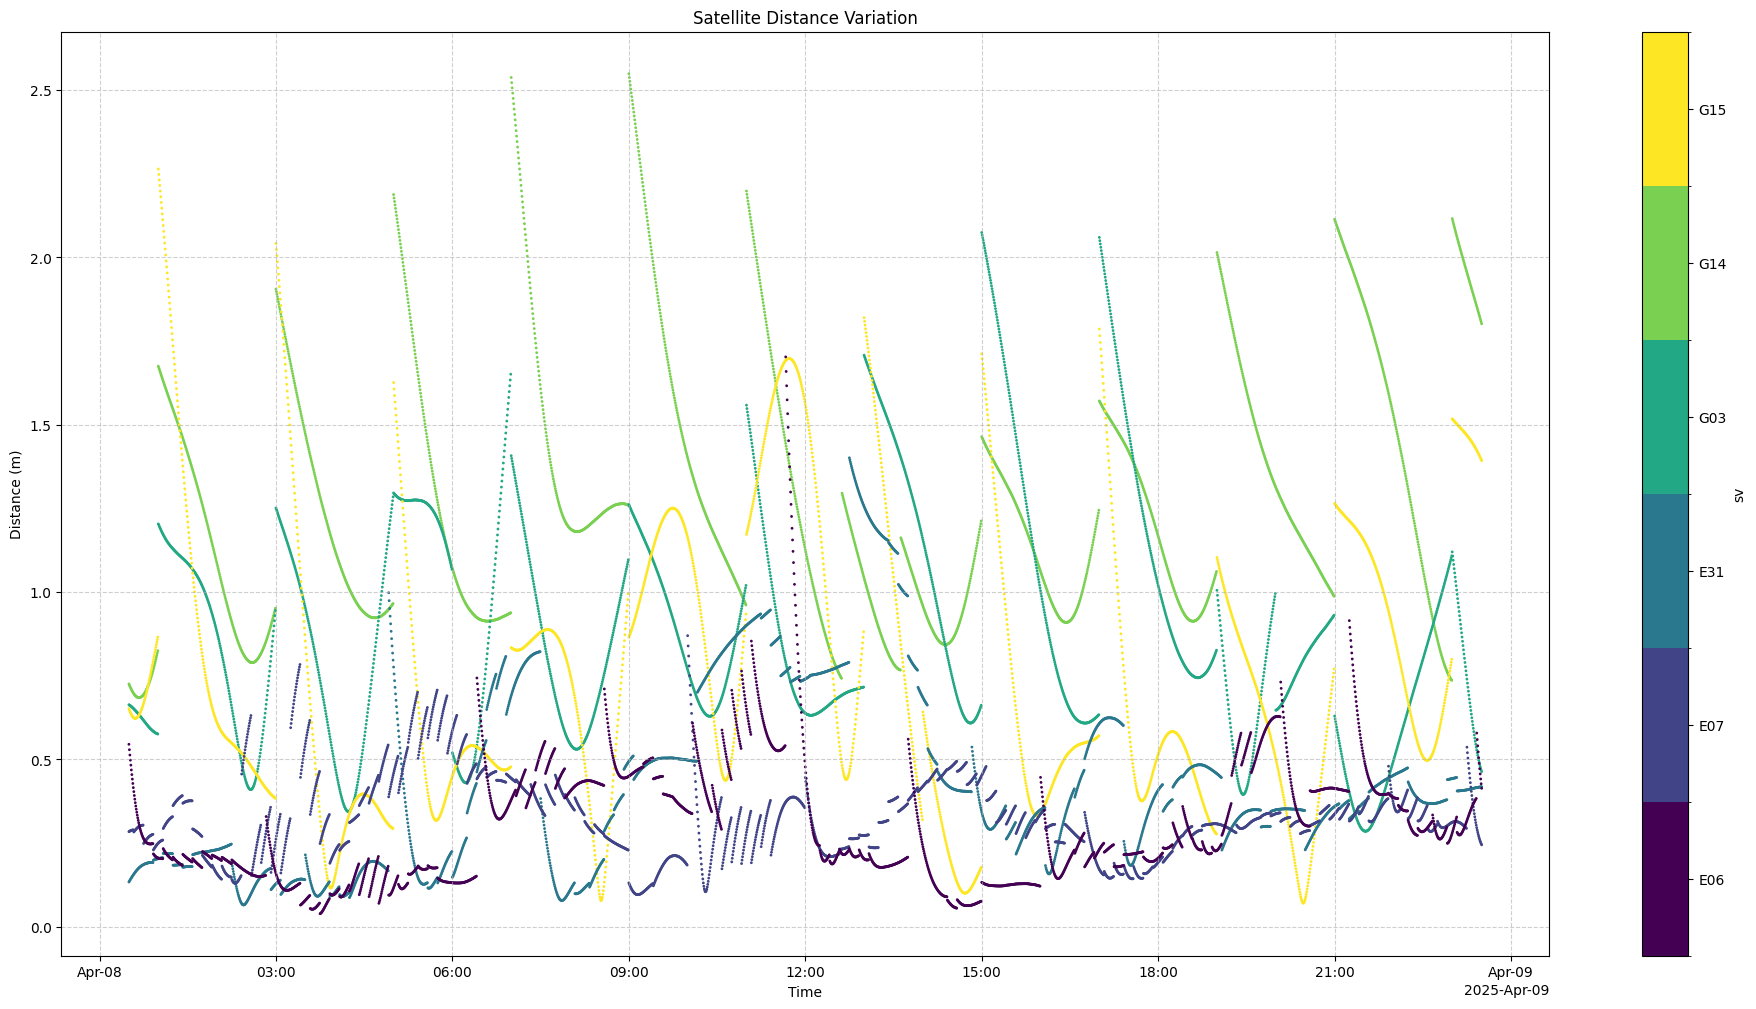

In [16]:
# distance_correction = distance(corrected_positions.position, positions_ephemeris.position)
distance_correction = distance(positions_ephemeris.position, corrected_positions.position)
plot_distance(distance_correction)